# POWER MEASUREMENT: UWB SHIELD

**Author**: Miglioranza Ettore<br>                                                
**Course**: Embedded systems [140502][146037] - 2025/26<br>  
**Teachers**: Prof. Davide Brunelli, Dr. Maria Doglioni<br>  

## Purpose of the notebook
This notebook is the report of the first lab session of the course Embedded Systems. The goal of this lab was to evaluate the power consumption of a low-power Ultra Wide Band (UWB) board based on the DWM1001 module.

## Introduction

The four key metrics of evaluation of embedded processors are:
- Code size
- Memory system performance
- Predictability
- Energy efficiency

Power usage in embedded processors is affected both by the *Instruction Set Architecture* (through instruction complexity, memory access patterns, etc.), and other factors, like microarchitecture, clock speed, and fabrication technology.

In this lab we focused on the **Energy efficiency** metric, and we had discovered how to effectively measure the power consumption of the hardware platform (**DWM1001 UWB board**). The **experiment's goal** was to understand how to characterize the power consumption of the UWB shield during real operation (transmit, receive, sleep). Measuring current draw over time and linking it to firmware states it's a useful method that can be applied to evaluate energy efficiency in other embedded designs too.

## Set Up

Before analyzing the results of the lab session, it's useful to do a brief introduction of the set up and components used.

1. **Hardware**

- **Main module**: DWM1001

- **Components**:

  - *BLE microprocessor* (Nordic nRF52832, ARM Cortex M4, 64 MHz)

  - *UWB transceiver* (Decawave DW1000)

  - *3-axis motion detector* (STM LIS2DH12TR)

  - *DC–DC converter* (2.8–3.6 V input)

- **Interfaces**: SPI, UART, I²C, GPIO, SWD

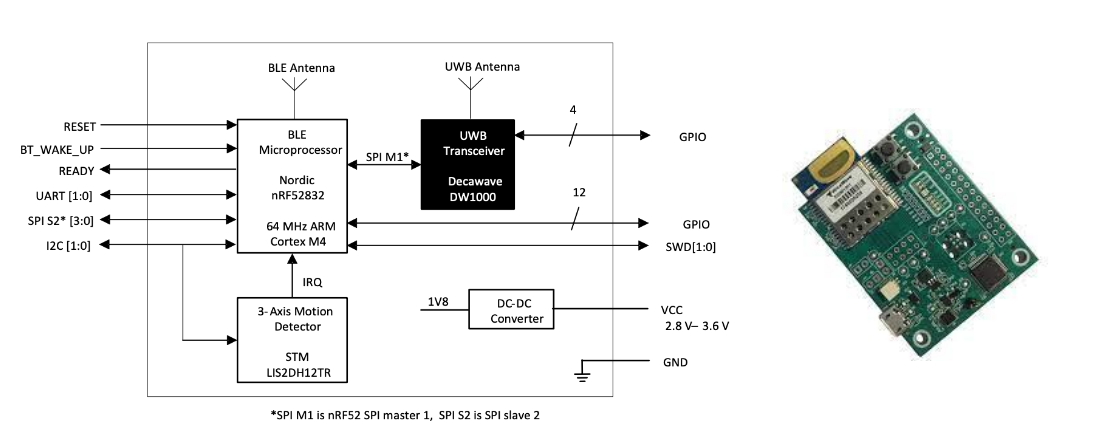

2. **Firmware workflow**

- The board runs at **64 MHz** and performs **beaconing** (sending packets periodically for localization).

- The loop sequence is:

  1. **Start**

  2. **Transmit (TX)** a packet

  3. **Receive (RX)** response

  4. If no response, wait 1 s and retry up to 5 times

  5. *Sleep for 5 s* before restarting the cycle

The system transmits periodic UWB signals while alternating between active (TX/RX) and low-power sleep states. We use the different states of the system to measure power consumption under realistic localization behavior.


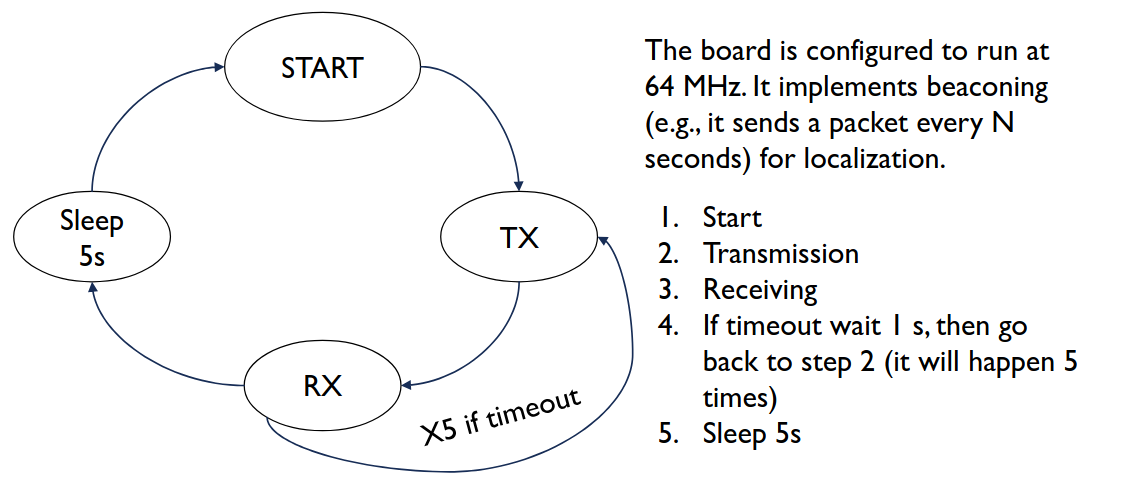

3. **Test bench setup**
- Measurement setup consists of two main instruments:
  - **Voltage Supply**:
    - *Device*: Keithley SourceMeter 2450
    - *Function*: Provides a stable 3.0 V supply to the UWB board and measures current consumption with microamp precision.
  - **Oscilloscope**:
    - *Device*: PicoScope 3403
    - *Function*: Captures **voltage waveforms** corresponding to the UWB board's activity phases (transmit, receive, sleep).
- **Connections**:
  - The red and black cables from the SourceMeter supply power to the circuit on the breadboard.
  - The oscilloscope proble is connected across the same supply lines to visualize voltage variations.
  - The probe's attenuation switch (1x/10x) controls measurement sensitivity.

Basically, we aim to measure both current and voltage, and this allows us to estimate
instantaneous power and energy consumption during different firmware states.

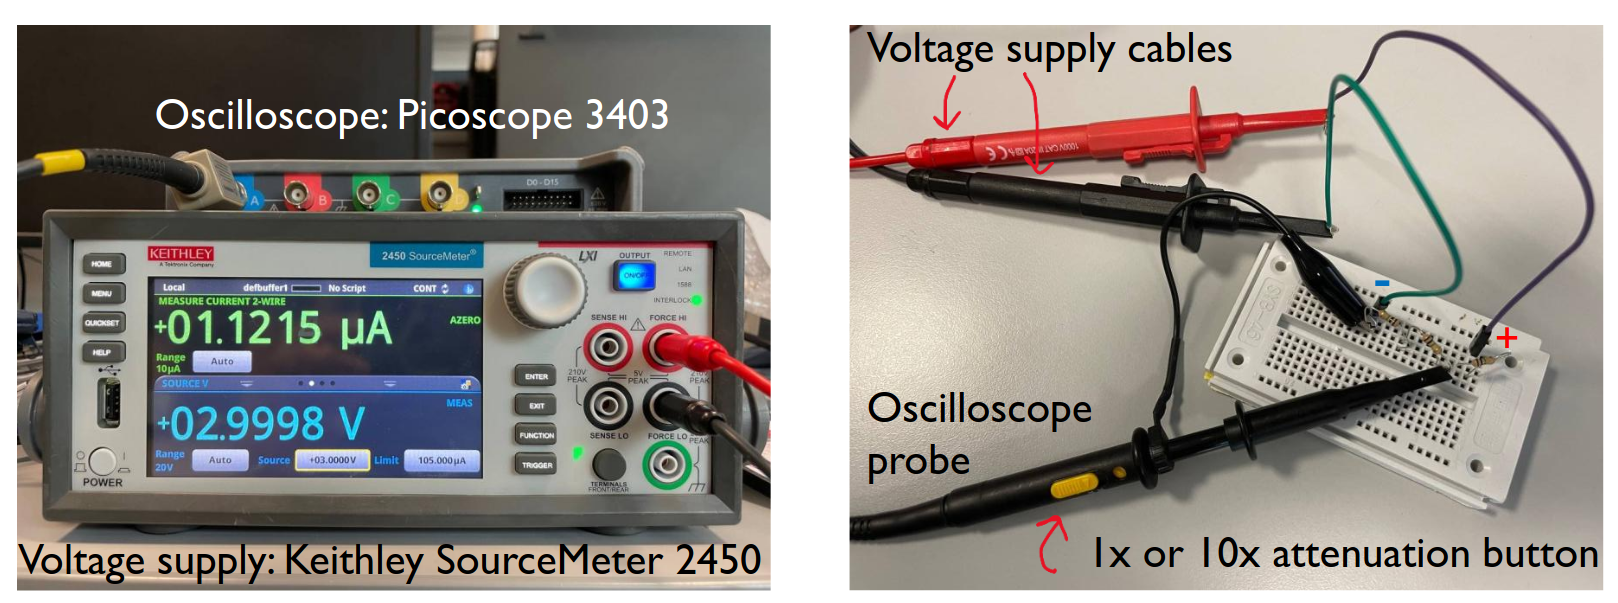

4. **Current-sensing set up**:
- For the current-sensing set up we physically connected the UWB board (load), the voltage supply, and the oscilloscope channels (A-D) to the breadboard (*First picture*).
- The breadboard resistors (1 Ω - 10 Ω) acts as sense resistor (Rsense).
- The oscilloscope probes (CH A–D) measure voltage at different points:
  - CH A and CH D read the voltage before and after Rsense (to compute current).
  - CH B and CH C measure the board’s supply voltage directly.

- The circuit diagram represents the electrical structure in simplified schematic form (*Second Picture*).
  - SUPPLY → the Keithley power source
  - RSENSE → the small resistor on the breadboard
  - LOAD → the UWB board
  - SENSE → the oscilloscope input measuring the voltage drop across Rsense


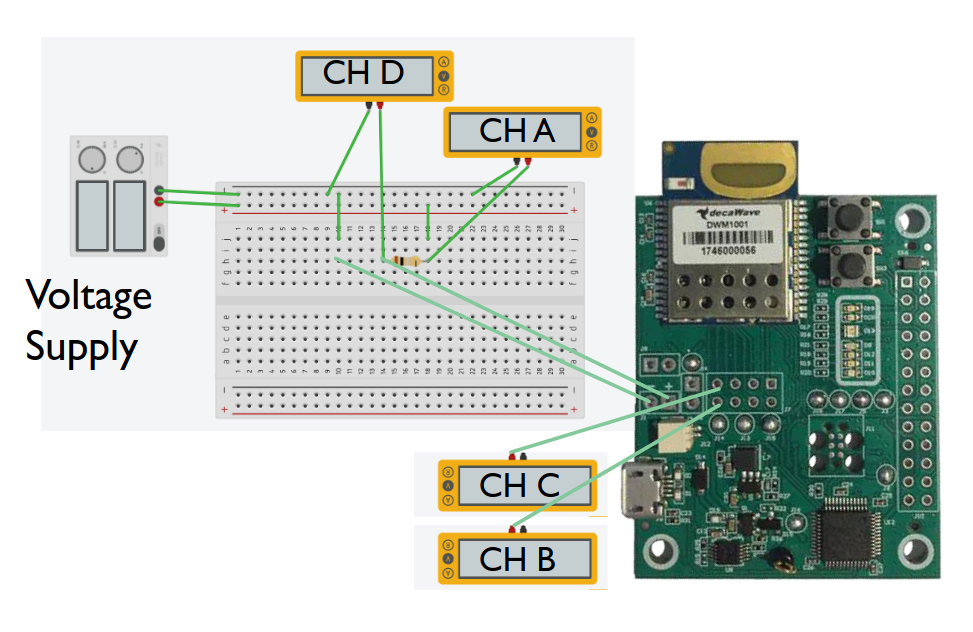

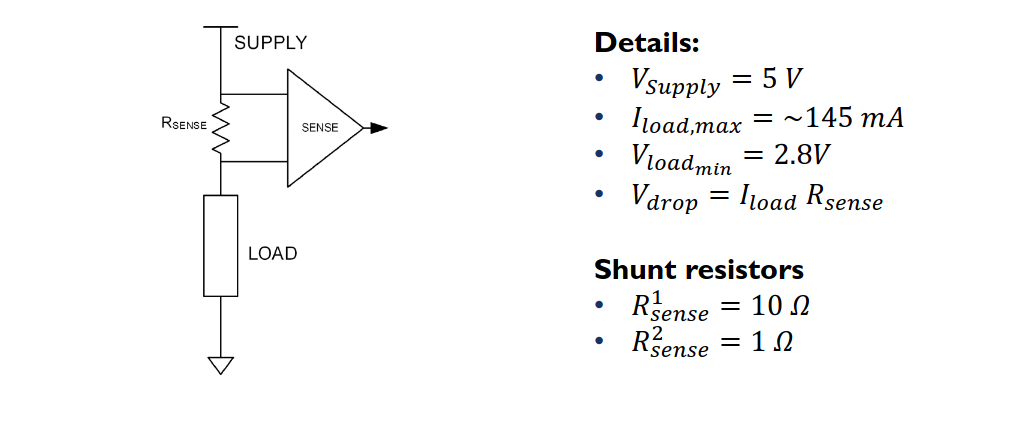

5. **First analysis of 10 Ohm shunt resistor**<br>

- Given that:
  -  R *sense* is in series with the power path of the board,
  - The Ch_A is the supply voltage and Ch_D is the load voltage,
  -  The probes of the PicoScope are correctly scaled (1x/10x).<br>

- If this conditions are met than the load current of the board is computed as:

$$
I(t)=\frac{V_A(t)-V_D(t)}{R_{\text{sense}}}
$$


- Subsequently, we recall that
$$
V_{drop}=V_A(t)-V_D(t)=I_{load}*R_{sense}
$$

- We wish to test if there exists intervals where<br>
$$
V_{load}(t)=V_{supply}(t)-V_{drop}(t) < V_{load_{min}}
$$

- To do so we compute the difference between the power supply and the minimum voltage of the load, any intervals in which $V_{drop}(t) > V_{supply}(t) - V_{load_{min}}$ we have a violations, thus we conclude that the shunt resistor is too big for our purpose.

In [38]:
# Useful libraries to conduct the analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
# Customized pandas parser to read this particul csv format
df = pd.read_csv(
    "10_ohm_res.csv",
    encoding='utf-8',
    sep=";",
    decimal=',',
    skiprows=2
)
# Personalizing columns
df.columns = ["Time(ms)", "CH_A(V)", "CH_B(V)", "CH_C(V)", "CH_D(V)"]
# View of the data
display(df.head())

,Time(ms),CH_A(V),CH_B(V),CH_C(V),CH_D(V)
0,-29.991685,"4,89465400",1.855161,0.039524,"4,69749600"
1,-29.986685,"4,93402400",1.776267,0.039524,"4,73702000"
2,-29.981685,"4,89465400",1.815637,0.039524,"4,77654400"
3,-29.976685,"4,93402400",1.815637,0.000000,"4,77654400"
4,-29.971685,"4,93402400",1.815637,0.000000,"4,77654400"


In [40]:
# Replace '∞' with NaN in the specified columns
df[['CH_A(V)', 'CH_D(V)']] = df[['CH_A(V)', 'CH_D(V)']].replace('∞', float(5))

In [41]:
## Dev Note ##
# .str.:  activate pandas vectorized string method, which
#         applies the .replace method to each Series value.
#         Without it we would have just the method searching
#         for the Series value equal to ",". which is no one;
df[['CH_A(V)', 'CH_D(V)']] = (
    df[['CH_A(V)', 'CH_D(V)']]
    .astype(str)
    .apply(lambda s: s.str.replace(',', '.'))
    .astype(float)
)

In [42]:
# Checking conversion worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time(ms)  100003 non-null  float64
 1   CH_A(V)   100003 non-null  float64
 2   CH_B(V)   100003 non-null  float64
 3   CH_C(V)   100003 non-null  float64
 4   CH_D(V)   100003 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB


In [43]:
Vmin_in = 2.8  # from spec
VA = df["CH_A(V)"]; VD = df["CH_D(V)"]
Vdrop = VA - VD
viol = Vdrop > (VA - Vmin_in)   # equivalently: VD < Vmin_in
viol[viol == True].count() # we print the number of violations

np.int64(6058)

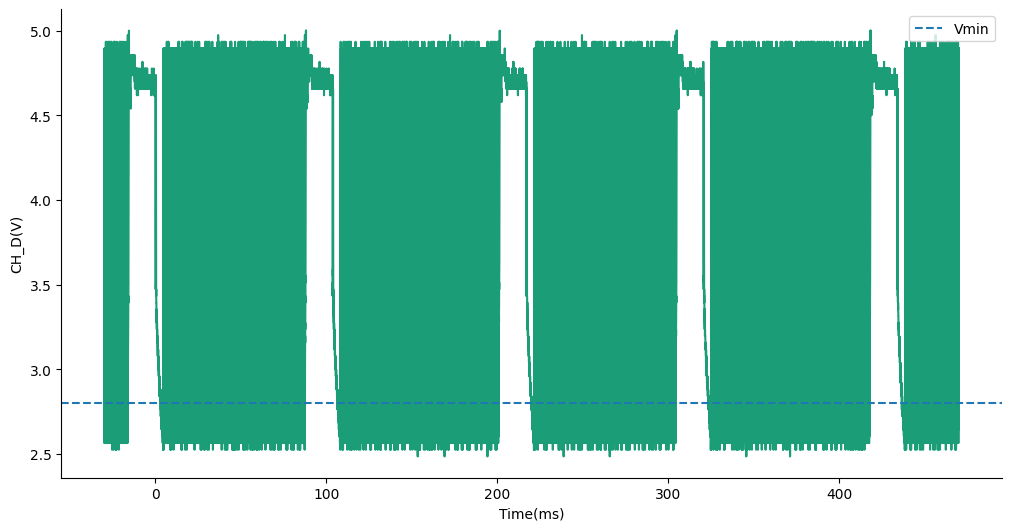

In [44]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time(ms)']
  ys = series['CH_D(V)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Time(ms)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time(ms)')
plt.axhline(Vmin_in, ls="--", label="Vmin")
_ = plt.ylabel('CH_D(V)')
plt.legend()

- The previous analysis conducted showed that the out of the sampled data points, 6058 violate the minimum load voltage requirement (2.8 V).
- *Interpretation*: during this samples the measured load voltage $V_{D}(t)$ dropped below 2.8 V. That means that the shunt resistor caused exessive voltage drop across itself during current peaks, so the board momentarily received insufficient voltage.
- *Conclusion*: the 10 Ohm shunt introduces too large drop for the circuit's current draw. A smaller sense resistor is required to stay within the supply-voltage limits.

6. **Visualization of 1 Ohm shunt resistor**



In [45]:
# Customized pandas parser to read this particul csv format
df = pd.read_csv(
    "1_ohm_res.csv",
    encoding='utf-8',
    sep=";",
    decimal=',',
    skiprows=2
)
# Personalizing columns
df.columns = ["Time(s)", "CH_A(V)", "CH_B(V)", "CH_C(V)", "CH_D(V)"]
# View of the data
display(df.head())

,Time(s),CH_A(V),CH_B(V),CH_C(V),CH_D(V)
0,-0.5999,"4,93402400",-0.03937,0.000000,"4,89496200"
1,-0.5998,"4,93402400",-0.03937,0.000000,"4,93433200"
2,-0.5997,"4,89465400",0.00000,0.039524,"4,89496200"
3,-0.5996,"4,89465400",0.00000,0.039524,"4,89496200"
4,-0.5995,"4,93402400",0.00000,0.000000,"4,93433200"


In [46]:
# Replace '∞' with NaN in the specified columns
df[['CH_A(V)', 'CH_D(V)']] = df[['CH_A(V)', 'CH_D(V)']].replace('∞', float(5))

In [47]:
# Replace , with .
df[['CH_A(V)', 'CH_D(V)']] = (
    df[['CH_A(V)', 'CH_D(V)']]
    .astype(str)
    .apply(lambda s: s.str.replace(',', '.'))
    .astype(float)
)

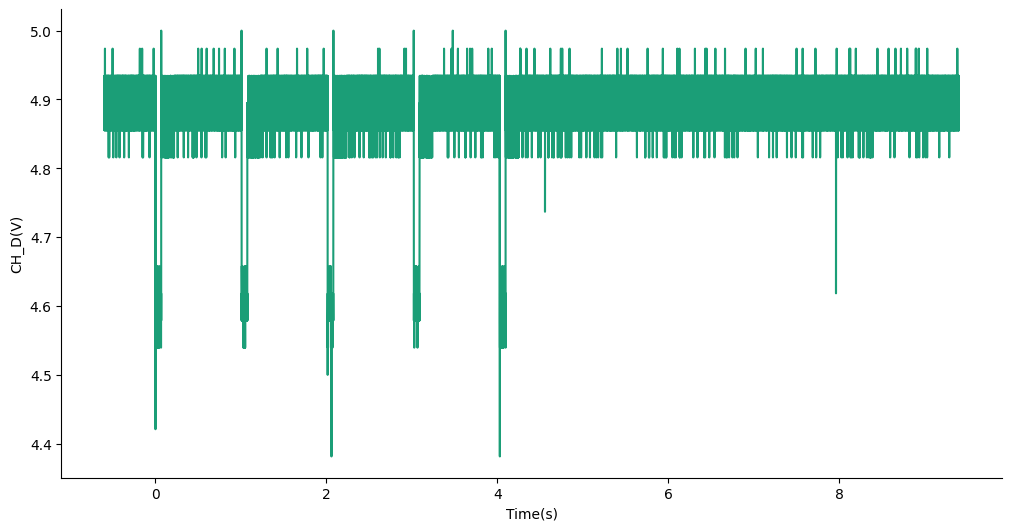

In [48]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time(s)']
  ys = series['CH_D(V)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Time(s)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time(s)')
_ = plt.ylabel('CH_D(V)')

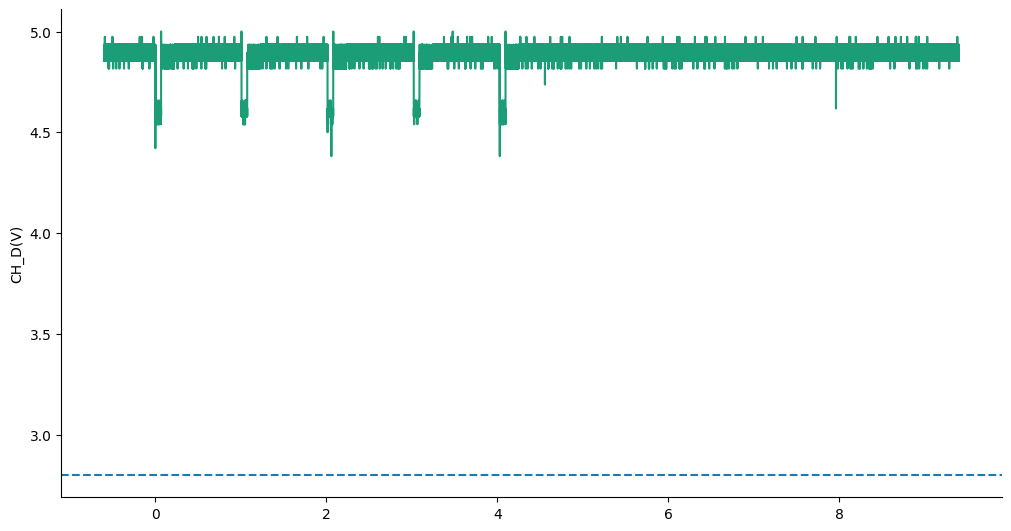

In [49]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Time(s)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.axhline(Vmin_in, ls="--", label="Vmin")
_ = plt.ylabel('CH_D(V)')

As we can see with 1 Ohm shunt there aren't any violations, so we can proceed with the Assignement 1.  

*First some useful visualization.*

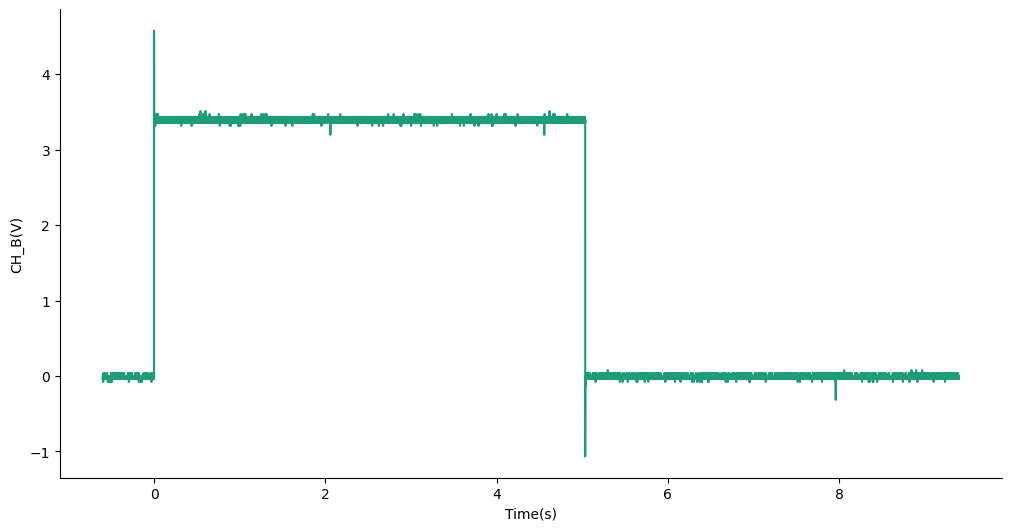

In [50]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time(s)']
  ys = series['CH_B(V)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Time(s)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time(s)')
_ = plt.ylabel('CH_B(V)')

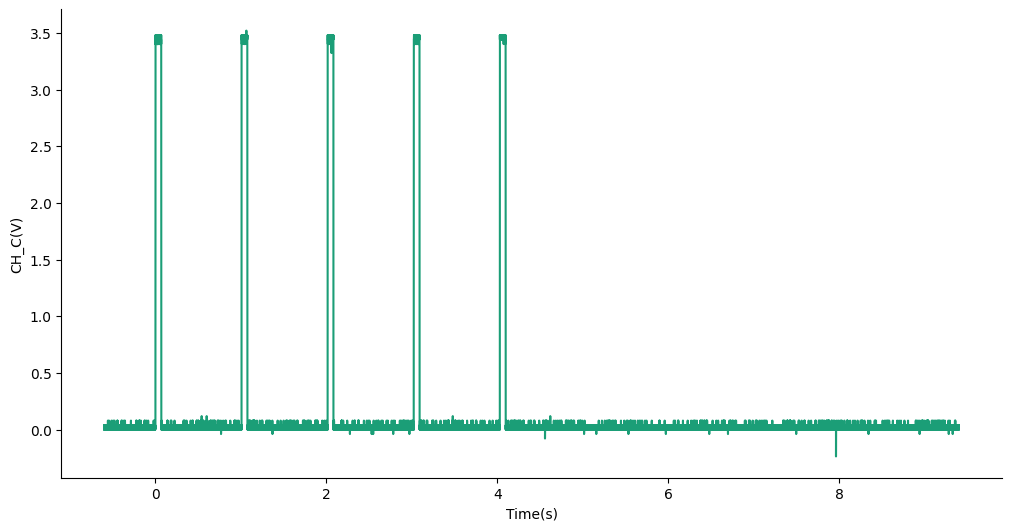

In [51]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time(s)']
  ys = series['CH_C(V)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Time(s)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time(s)')
_ = plt.ylabel('CH_C(V)')

**Intepretation of CH B and C's time series plot**

- CH B: the plot shows the alimentation state and the microprocessor activity. It's 0 when the micro is inactive and > 3.3 V when it is operating.
- CH C: the probes is connected with a digital exit pin (GPIO) and it measures the logic voltage emitted by the micro during the execution of its firmware.The graph shows a series of repetitive pulses:
  - 0 V → low logic level (off).
  - ~3.5 V → high logic level (transmission).


*Computations*

### ---  TX average power and energy consumption ---

In [52]:
shunt_1 = 1  # ohms
txs_mask = df["CH_C(V)"] >= 3.0
tx_mask_1 = (df["CH_C(V)"] >= 3.0) & (df["Time(s)"] < 0.5)
tx_mask_2 = (df["CH_C(V)"] >= 3.0) & (df["Time(s)"] > 0.5) & (df["Time(s)"] < 1.5)
tx_mask_3 = (df["CH_C(V)"] >= 3.0) & (df["Time(s)"] > 1.5) & (df["Time(s)"] < 2.5)
tx_mask_4 = (df["CH_C(V)"] >= 3.0) & (df["Time(s)"] > 2.5) & (df["Time(s)"] < 3.5)
tx_mask_5 = (df["CH_C(V)"] >= 3.0) & (df["Time(s)"] > 3.5) & (df["Time(s)"] < 4.5)

# ---- Burst 1 ----
t1_min = df["Time(s)"][tx_mask_1].min()
t1_max = df["Time(s)"][tx_mask_1].max()
t1_duration_s = (t1_max - t1_min)

# ---- Burst 2 ----
t2_min = df["Time(s)"][tx_mask_2].min()
t2_max = df["Time(s)"][tx_mask_2].max()
t2_duration_s = (t2_max - t2_min)

# ---- Burst 3 ----
t3_min = df["Time(s)"][tx_mask_3].min()
t3_max = df["Time(s)"][tx_mask_3].max()
t3_duration_s = (t3_max - t3_min)

# ---- Burst 4 ----
t4_min = df["Time(s)"][tx_mask_4].min()
t4_max = df["Time(s)"][tx_mask_4].max()
t4_duration_s = (t4_max - t4_min)

# ---- Burst 5 ----
t5_min = df["Time(s)"][tx_mask_5].min()
t5_max = df["Time(s)"][tx_mask_5].max()
t5_duration_s = (t5_max - t5_min)

# ---- Stampa dei risultati ----
print(f"Burst 1: {t1_duration_s} s")
print(f"Burst 2: {t2_duration_s} s")
print(f"Burst 3: {t3_duration_s} s")
print(f"Burst 4: {t4_duration_s} s")
print(f"Burst 5: {t5_duration_s} s")


T_tx = t1_duration_s + \
        t2_duration_s + \
        t3_duration_s + \
        t4_duration_s + \
        t5_duration_s

# Correct calculation of I_t and P_t using CH_A and CH_D
df["I_t"] = (df["CH_A(V)"] - df["CH_D(V)"]) / shunt_1
df["P_t"] = df["I_t"] * df["CH_D(V)"]
# Calculate time difference between consecutive samples
dt = np.gradient(df["Time(s)"])

# average power during TX [W]
# Use the tx_mask to select the relevant time steps and power values
P_tx_avg = np.sum(df["P_t"][txs_mask] * dt[txs_mask]) / (T_tx) # [W]

E_tx = P_tx_avg*T_tx  # [J]

# --- Prints ---
print("------ Transmission metrics ------")
print(f"TX duration: {T_tx:.6f} s")
print(f"Average TX power: {P_tx_avg:.6f} W  ({P_tx_avg*1e3:.3f} mW)")
print(f"AVG TX energy: {(E_tx/5):.6e} J  ({(E_tx/5)*1e3:.6f} mJ)")
print("----------------------------------")

Burst 1: 0.0677 s
Burst 2: 0.06759998999999994 s
Burst 3: 0.06769999999999987 s
Burst 4: 0.06759999999999966 s
Burst 5: 0.06769999999999943 s
------ Transmission metrics ------
TX duration: 0.338300 s
Average TX power: 0.517117 W  (517.117 mW)
AVG TX energy: 3.498813e-02 J  (34.988133 mJ)
----------------------------------


In [53]:
P_bursts = []
E_bursts = []

for mask, T in zip([tx_mask_1, tx_mask_2, tx_mask_3, tx_mask_4, tx_mask_5],
                   [t1_duration_s, t2_duration_s, t3_duration_s, t4_duration_s, t5_duration_s]):

    E_i = np.sum(df["P_t"][mask] * dt[mask])
    P_i = E_i / T if T > 0 else np.nan

    E_bursts.append(E_i)
    P_bursts.append(P_i)

std_E = np.std(E_bursts, ddof=1)
std_P = np.std(P_bursts, ddof=1)

print("------ Statistics over bursts ------")
print(f"STD  burst energy: {std_E*1e3:.6e} mJ")
print(f"STD  burst power:  {std_P*1e3:.6f} mW")
print("------------------------------------")

------ Statistics over bursts ------
STD  burst energy: 3.164949e-01 mJ
STD  burst power:  4.618597 mW
------------------------------------


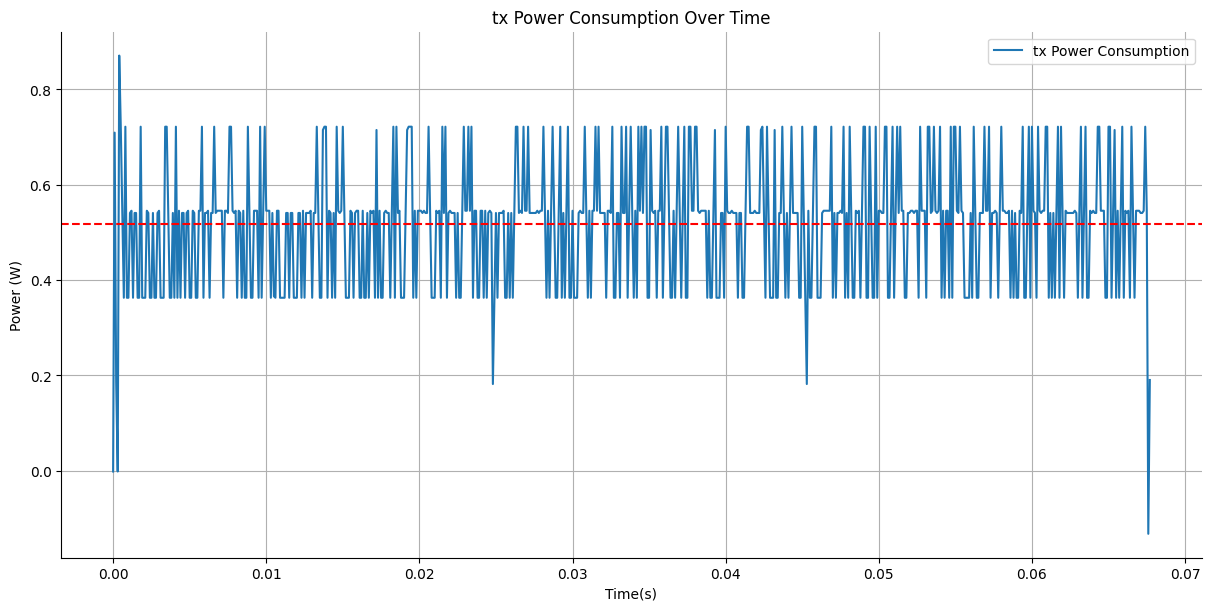

In [54]:
fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

# Plot ser_test (power consumption during idle periods) against corresponding time values
ax.plot(df["Time(s)"][tx_mask_1], df["P_t"][tx_mask_1], label='tx Power Consumption')

sns.despine(fig=fig, ax=ax)
plt.xlabel('Time(s)')
plt.ylabel('Power (W)')
plt.title('tx Power Consumption Over Time')
plt.legend()
ax.axhline(P_tx_avg, color='red', linestyle='--', label=f'Average tx Power ({P_tx_avg:.4f} W)')
plt.grid(True)
plt.show()

### ---  Idle average power and energy consumption ---

In [55]:
shunt_1 = 1  # ohm
idles_mask = df["CH_C(V)"] < 3.0
right_limit = 5.0
idles_mask_corr = (df["CH_C(V)"] < 3.0) & (df["Time(s)"] > 0.0) & (df["Time(s)"] < right_limit)
idle_mask_1 = (df["CH_C(V)"] < 3.0) & (df["Time(s)"] >= 0.0) & (df["Time(s)"] < 1.0)
idle_mask_2 = (df["CH_C(V)"] < 3.0) & (df["Time(s)"] >= 1.0) & (df["Time(s)"] < 2.0)
idle_mask_3 = (df["CH_C(V)"] < 3.0) & (df["Time(s)"] >= 2.0) & (df["Time(s)"] < 3.0)
idle_mask_4 = (df["CH_C(V)"] < 3.0) & (df["Time(s)"] >= 3.0) & (df["Time(s)"] < 4.0)
idle_mask_5 = (df["CH_C(V)"] < 3.0) & (df["Time(s)"] >= 4.0) & (df["Time(s)"] < 5.0)

# ---- Idle 1 ----
t1_min = df["Time(s)"][idle_mask_1].min()
t1_max = df["Time(s)"][idle_mask_1].max()
t1_duration_s = (t1_max - t1_min)

# ---- Idle 2 ----
t2_min = df["Time(s)"][idle_mask_2].min()
t2_max = df["Time(s)"][idle_mask_2].max()
t2_duration_s = (t2_max - t2_min)

# ---- Idle 3 ----
t3_min = df["Time(s)"][idle_mask_3].min()
t3_max = df["Time(s)"][idle_mask_3].max()
t3_duration_s = (t3_max - t3_min)

# ---- Idle 4 ----
t4_min = df["Time(s)"][idle_mask_4].min()
t4_max = df["Time(s)"][idle_mask_4].max()
t4_duration_s = (t4_max - t4_min)

# ---- Idle 5 ----
t5_min = df["Time(s)"][idle_mask_5].min()
t5_max = df["Time(s)"][idle_mask_5].max()
t5_duration_s = (t5_max - t5_min)

# ---- Stampa dei risultati ----
print(f"Idle 1: {t1_duration_s} s")
print(f"Idle 2: {t2_duration_s} s")
print(f"Idle 3: {t3_duration_s} s")
print(f"Idle 4: {t4_duration_s} s")
print(f"Idle 5: {t5_duration_s} s")

T_idle = t1_duration_s + \
        t2_duration_s + \
        t3_duration_s + \
        t4_duration_s + \
        t5_duration_s

# Correct calculation of I_t and P_t using CH_A and CH_D
df["I_t"] = (df["CH_A(V)"] - df["CH_D(V)"]) / shunt_1
df["P_t"] = df["I_t"] * df["CH_D(V)"]
# Calculate time difference between consecutive samples
dt = np.gradient(df["Time(s)"])

# average power during idle [W]
# Use the idle_mask to select the relevant time steps and power values
P_idle_avg = np.sum(df["P_t"][idles_mask_corr] * dt[idles_mask_corr]) / (T_idle) # [W]

E_idle = np.sum(df["P_t"][idles_mask_corr] * dt[idles_mask_corr])  # [J]

# --- Prints ---
print("------ Transmission metrics ------")
print(f"idle duration: {T_idle:.6f} s")
print(f"Average idle power: {P_idle_avg:.6f} W  ({P_idle_avg*1e3:.3f} mW)")
print(f"Average idle energy: {(E_idle/5):.6e} J  ({(E_idle/5)*1e3:.6f} mJ)")
print("----------------------------------")

Idle 1: 0.93209998 s
Idle 2: 0.99999997 s
Idle 3: 0.99989997 s
Idle 4: 0.9998999799999999 s
Idle 5: 0.9998999699999995 s
------ Transmission metrics ------
idle duration: 4.931800 s
Average idle power: 0.054638 W  (54.638 mW)
Average idle energy: 5.389277e-02 J  (53.892770 mJ)
----------------------------------


In [56]:
P_idle = []
E_idle = []

for mask, T in zip([idle_mask_1, idle_mask_2, idle_mask_3, idle_mask_4],
                   [t1_duration_s, t2_duration_s, t3_duration_s, t4_duration_s]):

    E_i = np.sum(df["P_t"][mask] * dt[mask])
    P_i = E_i / T if T > 0 else np.nan

    E_idle.append(E_i)
    P_idle.append(P_i)

std_E = np.std(E_idle, ddof=1)
std_P = np.std(P_idle, ddof=1)

print("------ Statistics over bursts ------")
print(f"STD  burst energy: {std_E*1e3:.6e} mJ")
print(f"STD  burst power:  {std_P*1e3:.6f} mW")
print("------------------------------------")

------ Statistics over bursts ------
STD  burst energy: 1.511352e+00 mJ
STD  burst power:  2.351642 mW
------------------------------------


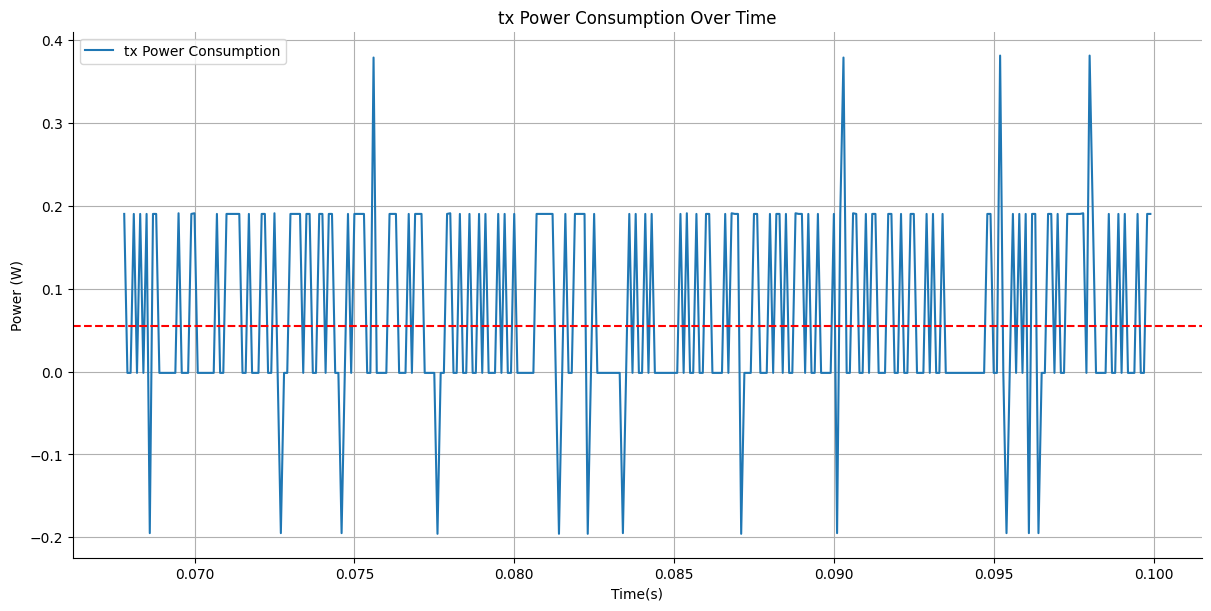

In [57]:
fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

visual_mask = (idle_mask_1) & (df["Time(s)"] > 0.01) & (df["Time(s)"] < 0.1)

# Plot ser_test (power consumption during idle periods) against corresponding time values
ax.plot(df["Time(s)"][visual_mask], df["P_t"][visual_mask], label='tx Power Consumption')

sns.despine(fig=fig, ax=ax)
plt.xlabel('Time(s)')
plt.ylabel('Power (W)')
plt.title('tx Power Consumption Over Time')
plt.legend()
ax.axhline(P_idle_avg, color='red', linestyle='--', label=f'Average tx Power ({P_idle_avg:.4f} W)')
plt.grid(True)
plt.show()

### --- Total Power and Current consumption over time ---

In [58]:
# Full task average power
actv_mask = df["CH_B(V)"] > 3.0
T_tot = (df["Time(s)"][actv_mask].max() - df["Time(s)"][actv_mask].min())
P_avg = np.sum(df["P_t"][actv_mask] * dt[actv_mask]) / T_tot # Convert T_idle to seconds
E_tot = P_avg*T_tot

# --- Prints ---
print("------ Transmission metrics ------")
print(f"Full Task duration: {T_tot:.6f} s")
print(f"Average Full Task power: {P_avg:.6f} W  ({P_avg*1e3:.3f} mW)")
print(f"Task energy: {E_tot:.6e} J  ({E_tot*1e3:.6f} mJ)")
print("----------------------------------")

------ Transmission metrics ------
Full Task duration: 5.036200 s
Average Full Task power: 0.088662 W  (88.662 mW)
Task energy: 4.465183e-01 J  (446.518278 mJ)
----------------------------------


Since no further task executions are available, the total energy and power constitute a single measure; consequently, the standard deviation for the full task is not mathematically definable.

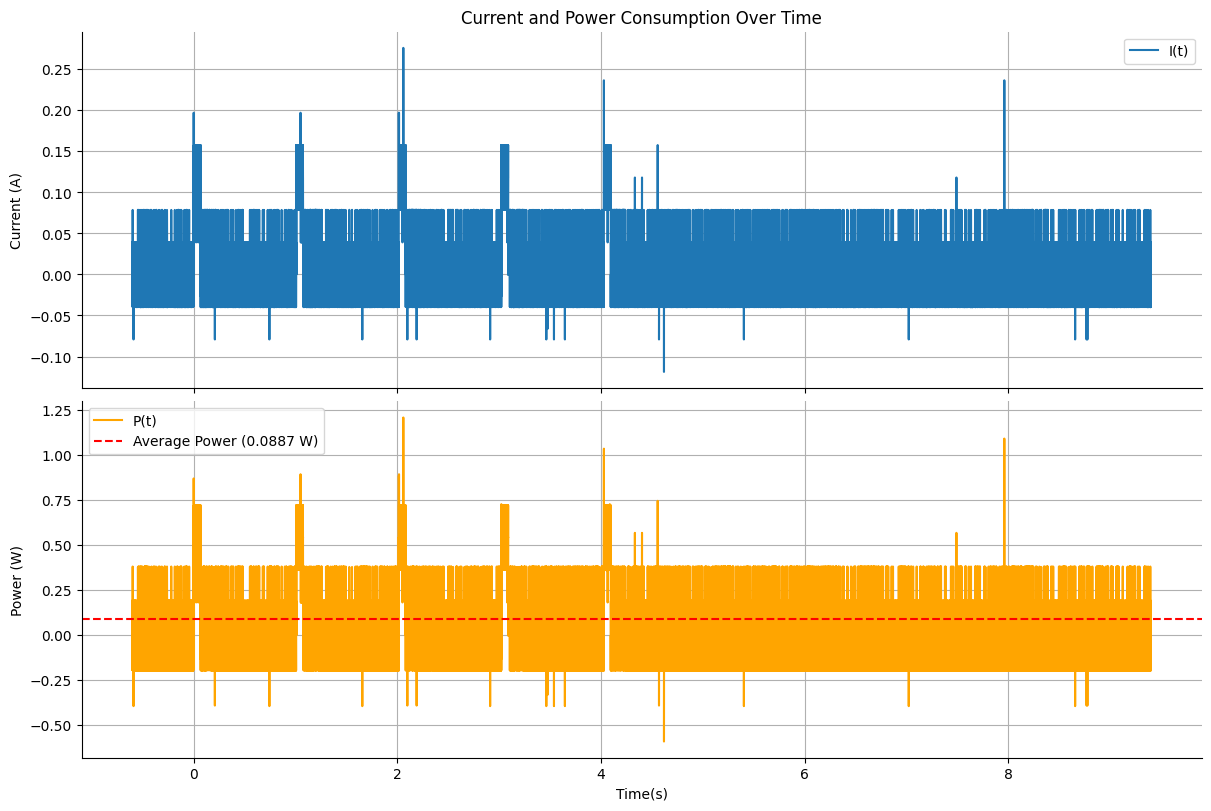

In [59]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, layout='constrained')

# Plot I_t
axes[0].plot(df["Time(s)"], df["I_t"], label='I(t)')
axes[0].set_ylabel('Current (A)')
axes[0].set_title('Current and Power Consumption Over Time')
axes[0].grid(True)
axes[0].legend()

# Plot P_t
axes[1].plot(df["Time(s)"], df["P_t"], label='P(t)', color='orange')
axes[1].set_xlabel('Time(s)')
axes[1].set_ylabel('Power (W)')
axes[1].axhline(P_avg, color='red', linestyle='--', label=f'Average Power ({P_avg:.4f} W)')
axes[1].grid(True)
axes[1].legend()

sns.despine(fig=fig)
plt.show()